<a href="https://colab.research.google.com/github/Yandres25/CardioByKeras/blob/main/KerasFiles/clas_cardio_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de Enfermedad Arterial Coronaria por KEras


**Objetivo:**
El objetivo de este notebook es construir, entrenar y evaluar una red neuronal para clasificar si un paciente tiene la posibilidad de tener Enfermedad coronaria utilizando Keras. Se incorporarán técnicas de preprocesamiento, regularización (L2 y Dropout) y callbacks de Keras (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau) para mejorar el entrenamiento y la robustez del modelo.

## 1. Carga de Librerías y Configuración Inicial

Importar todas las bibliotecas necesarias y configurar el entorno para el análisis, incluyendo la fijación de semillas para reproducibilidad.


In [1]:
# Comandos mágicos de IPython (opcional en scripts)
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Importación de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Configuración para reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configuración de estilo y visualización
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

In [3]:

url = "https://raw.githubusercontent.com/Yandres25/FuzzySystem/main/CardioRisk/cardio.csv"




## 2. Funciones Personalizadas

### Descripción de la Función: `cargar_y_preparar_datos`

Cargar el dataset cardio.csv, realizar preprocesamiento básico (escalado de características, conversion a numéricas por get_dummies) y dividirlo en conjuntos de entrenamiento y prueba.


In [4]:
def cargar_y_preparar_datos_cardio(nombre_archivo, target_col, test_size=0.3, random_state=SEED):
    df = pd.read_csv(url)

    print(df.head())

    #Eliminar columna ind
    #Teniendo en cuenta que se usó el mismo dataset de sistema fuzzy, se elimina la columna ind y se mantiene el resto de características.
    df = df.drop(columns=['ind'])

    print("\nDescripción del dataset:")
    print(df.describe().T)

    print("\nPrimeras filas del dataset:")
    print(df.head())
    print("\nDescripción del dataset:")
    print(df.describe().T)

    # Codificar la variable categórica (por ejemplo: famhist)
    df = pd.get_dummies(df, drop_first=True)

    # Separar X e y
    y = df[target_col].values
    X = df.drop(columns=[target_col])
    feature_names = X.columns.tolist()

    # Escalar características
    # Escalar características
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Codificación One-Hot para el objetivo
    y_categorical = to_categorical(y)

    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_categorical, test_size=test_size, random_state=random_state, stratify=y # stratify para clasificación
    )

    print(f"\nDimensiones: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    return X_train, X_test, y_train, y_test, scaler, feature_names

### Descripción de la Función: `crear_modelo_clasificacion_keras`

Definir y compilar un modelo de red neuronal secuencial con Keras para clasificación.


In [5]:
def crear_modelo_clasificacion_keras(input_dim, output_dim, l2_lambda=0.001, dropout_rate=0.25):
    """
    Crea un modelo de red neuronal para clasificación con Keras.
    """
    print("\nCreando el modelo de clasificación con Keras...")
    model = Sequential([
        Dense(64, activation='relu',input_shape=(input_dim,), kernel_regularizer=regularizers.l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(output_dim, activation='softmax') # Capa de salida para clasificación multiclase
    ])

    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    print("\nResumen del modelo:")
    model.summary()
    return model

### Gráfico de curvos de perdida y precisión

Graficar las curvas de pérdida y precisión del entrenamiento y validación.



In [6]:
def graficar_historial_entrenamiento(history):
    """
    Grafica la precisión y la pérdida durante el entrenamiento y validación.
    """
    print("\nGraficando historial de entrenamiento...")
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    epochs_range = range(len(acc if acc else val_acc if val_acc else loss if loss else val_loss)) # Manejar si alguna métrica no está

    plt.figure(figsize=(14, 5))

    if acc and val_acc:
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Precisión (Entrenamiento)')
        plt.plot(epochs_range, val_acc, label='Precisión (Validación)')
        plt.legend(loc='lower right')
        plt.title('Precisión de Entrenamiento y Validación')
        plt.xlabel('Épocas')
        plt.ylabel('Precisión')

    if loss and val_loss:
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Pérdida (Entrenamiento)')
        plt.plot(epochs_range, val_loss, label='Pérdida (Validación)')
        plt.legend(loc='upper right')
        plt.title('Pérdida de Entrenamiento y Validación')
        plt.xlabel('Épocas')
        plt.ylabel('Pérdida')

    if not (acc and val_acc and loss and val_loss): # Si faltan métricas para ambos gráficos
        if acc and val_acc: # Solo hay precisión
             plt.title('Precisión de Entrenamiento y Validación')
             plt.xlabel('Épocas'); plt.ylabel('Precisión')
        elif loss and val_loss: # Solo hay pérdida
            plt.title('Pérdida de Entrenamiento y Validación')
            plt.xlabel('Épocas'); plt.ylabel('Pérdida')

    plt.show()

### Evaluación del modelo de clasificación y Matriz de confusión

Evaluar el modelo de clasificación en el conjunto de prueba y visualizar la matriz de confusión.



In [7]:
def evaluar_y_visualizar_clasificacion(model, X_test, y_test_cat):
    """
    Evalúa el modelo de clasificación y visualiza la matriz de confusión.
    """
    print("\nEvaluando el modelo en el conjunto de prueba...")
    loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
    print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

    # Predicciones
    y_pred_proba = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)
    y_true_classes = np.argmax(y_test_cat, axis=1)

    # Reporte de Clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_true_classes, y_pred_classes, zero_division=0))

    # Matriz de Confusión
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

## 3. Desarrollo del Ejercicio: Clasificación de enfermedad coronaria con Keras

### 3.1. Carga y Preparación de Datos. Arquitectura prueba 1.

Cargamos el dataset cardio.csv, lo escalamos y lo dividimos en conjuntos de entrenamiento y prueba.

In [8]:
X_train, X_test, y_train, y_test, scaler, feature_names = cargar_y_preparar_datos_cardio(
    nombre_archivo ="cardio.csv",
    target_col="chd"
)

   ind  sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  \
0    1  160    12.00  5.73      23.11  Present     49    25.30    97.20   52   
1    2  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63   
2    3  118     0.08  3.48      32.28  Present     52    29.14     3.81   46   
3    4  170     7.50  6.41      38.03  Present     51    31.99    24.26   58   
4    5  134    13.60  3.50      27.78  Present     60    25.99    57.34   49   

   chd  
0    1  
1    1  
2    0  
3    1  
4    1  

Descripción del dataset:
           count        mean        std     min       25%      50%       75%  \
sbp        462.0  138.326840  20.496317  101.00  124.0000  134.000  148.0000   
tobacco    462.0    3.635649   4.593024    0.00    0.0525    2.000    5.5000   
ldl        462.0    4.740325   2.070909    0.98    3.2825    4.340    5.7900   
adiposity  462.0   25.406732   7.780699    6.74   19.7750   26.115   31.2275   
typea      462.0   53.103896   9.817534

### 3.2. Creación del Modelo de Clasificación

Definimos la arquitectura de nuestra red neuronal usando Keras.

In [9]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1] # Número de clases (después de to_categorical)

modelo = crear_modelo_clasificacion_keras(input_dim, output_dim, l2_lambda=0.005, dropout_rate=0.25)


Creando el modelo de clasificación con Keras...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Resumen del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,786 (10.88 KB)

 Trainable params: 2,786 (10.88 KB)

 Non-trainable params: 0 (0.00 B)

### 3.3. Entrenamiento del Modelo

Entrenamos el modelo, utilizando callbacks para mejorar el proceso.
* `EarlyStopping`: Detiene el entrenamiento si la pérdida de validación no mejora tras `patience` épocas.
* `ModelCheckpoint`: Guarda el modelo con el mejor rendimiento en el conjunto de validación.
* `ReduceLROnPlateau`: Reduce la tasa de aprendizaje si la pérdida de validación se estanca.

In [10]:
print("\nIniciando el entrenamiento del modelo Cardio...")

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001, verbose=1)

callbacks_list = [early_stopping, model_checkpoint, reduce_lr]

# Entrenamiento
history = modelo.fit(
    X_train, y_train,
    epochs=200, # Un número alto de épocas, EarlyStopping se encargará
    batch_size=8, # Lotes pequeños para Iris
    validation_split=0.2, # Usar una porción de los datos de entrenamiento para validación interna
    callbacks=callbacks_list,
    verbose=1 # 0 = silent, 1 = progress bar, 2 = one line per epoch.
)

# Cargar el mejor modelo guardado por ModelCheckpoint (si restore_best_weights=False en EarlyStopping)
# Si restore_best_weights=True en EarlyStopping, esto no es estrictamente necesario ya que el modelo ya tiene los mejores pesos.
# modelo_iris = keras.models.load_model('best_model.keras')


Iniciando el entrenamiento del modelo Cardio...
Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5836 - loss: 0.9799
Epoch 1: val_loss improved from inf to 0.87653, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5852 - loss: 0.9788 - val_accuracy: 0.6615 - val_loss: 0.8765 - learning_rate: 0.0010
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6935 - loss: 0.8702
Epoch 2: val_loss improved from 0.87653 to 0.85025, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6938 - loss: 0.8700 - val_accuracy: 0.6769 - val_loss: 0.8503 - learning_rate: 0.0010
Epoch 3/200
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7311 - loss: 0.7758   
Epoch 3: val_loss improved from 0.85025 to 0.82522, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7299 - loss: 0.7815 - val_accuracy: 0.7077 - val_loss: 0.8252 - learning_rate: 0.0010
Epoch 4/200
28/33 ━━━━━

### 3.4. Visualización del Historial de Entrenamiento

Observamos cómo evolucionaron la precisión y la pérdida durante el entrenamiento.


Graficando historial de entrenamiento...


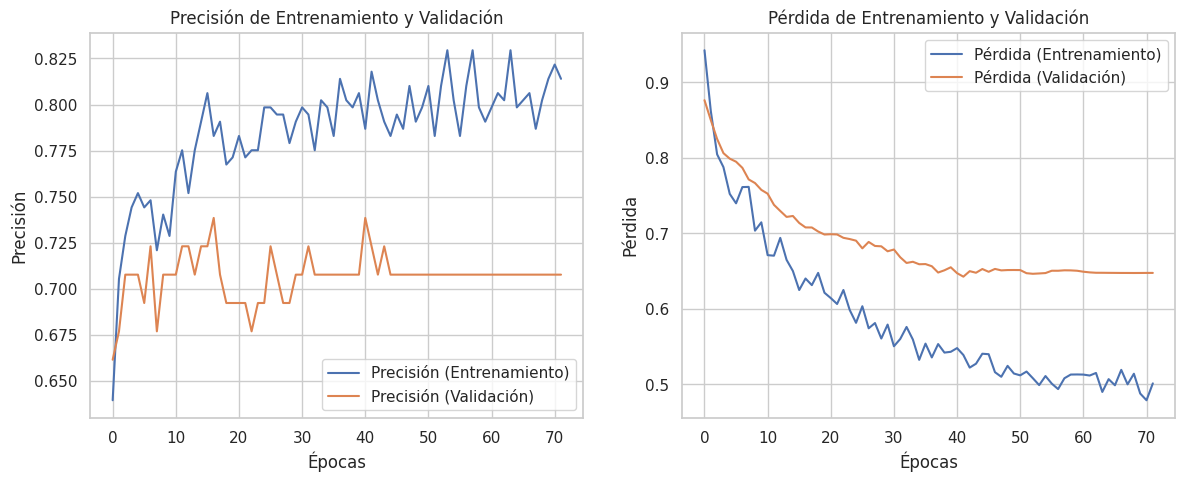

In [11]:
if history:
    graficar_historial_entrenamiento(history)

### 3.5. Evaluación del Modelo

Evaluamos el rendimiento del modelo entrenado en el conjunto de prueba.


Evaluando el modelo en el conjunto de prueba...
Pérdida en el conjunto de prueba: 0.6555
Precisión en el conjunto de prueba: 0.7482
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81        91
           1       0.64      0.62      0.63        48

    accuracy                           0.75       139
   macro avg       0.72      0.72      0.72       139
weighted avg       0.75      0.75      0.75       139



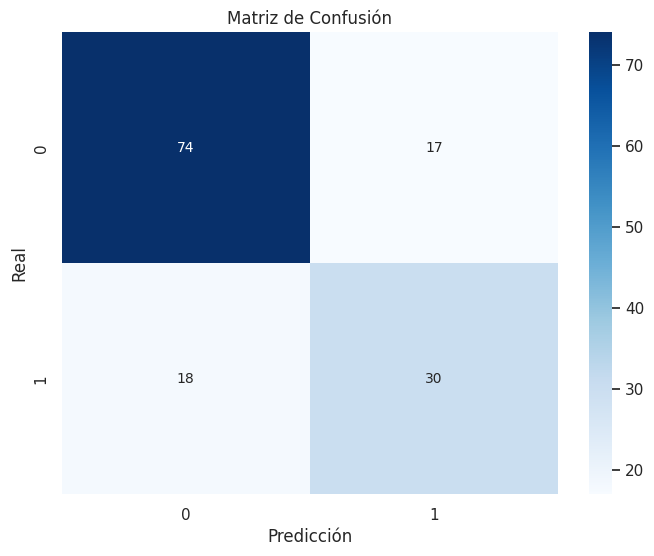

In [12]:
if modelo:
    evaluar_y_visualizar_clasificacion(modelo, X_test, y_test)

### 3.6 Función Arquitectura Prueba 2.

Se aplica nueva capa oculta y modificando otros hiperparametros.


In [13]:
def crear_modelo_clasificacion_keras_2(input_dim2, output_dim2, l2_lambda=0.001, dropout_rate=0.5):
    """
    Crea un modelo de red neuronal para clasificación con Keras.
    """
    print("\nCreando el modelo de clasificación con Keras...")
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim2,), kernel_regularizer=regularizers.l2(l2_lambda)),
        Dropout(dropout_rate),

        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        Dropout(dropout_rate),

        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        Dropout(dropout_rate),

        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(output_dim2, activation='softmax') # Capa de salida para clasificación multiclase
    ])

    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    print("\nResumen del modelo:")
    model.summary()
    return model

In [14]:
X_train, X_test, y_train, y_test, scaler, feature_names = cargar_y_preparar_datos_cardio(
    nombre_archivo ="cardio.csv",
    target_col="chd"
)

   ind  sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  \
0    1  160    12.00  5.73      23.11  Present     49    25.30    97.20   52   
1    2  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63   
2    3  118     0.08  3.48      32.28  Present     52    29.14     3.81   46   
3    4  170     7.50  6.41      38.03  Present     51    31.99    24.26   58   
4    5  134    13.60  3.50      27.78  Present     60    25.99    57.34   49   

   chd  
0    1  
1    1  
2    0  
3    1  
4    1  

Descripción del dataset:
           count        mean        std     min       25%      50%       75%  \
sbp        462.0  138.326840  20.496317  101.00  124.0000  134.000  148.0000   
tobacco    462.0    3.635649   4.593024    0.00    0.0525    2.000    5.5000   
ldl        462.0    4.740325   2.070909    0.98    3.2825    4.340    5.7900   
adiposity  462.0   25.406732   7.780699    6.74   19.7750   26.115   31.2275   
typea      462.0   53.103896   9.817534

In [15]:
input_dim2 = X_train.shape[1]
output_dim2 = y_train.shape[1] # Número de clases (después de to_categorical)

modelo2 = crear_modelo_clasificacion_keras_2(input_dim2, output_dim2, l2_lambda=0.005, dropout_rate=0.50)


Creando el modelo de clasificación con Keras...

Resumen del modelo:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,842 (61.88 KB)

 Trainable params: 15,842 (61.88 KB)

 Non-trainable params: 0 (0.00 B)

### 3.7 Entrenamiento Arquitectura 2

In [16]:
print("\nIniciando el entrenamiento del modelo Cardio...")

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001, verbose=1)

callbacks_list = [early_stopping, model_checkpoint, reduce_lr]

# Entrenamiento
history2 = modelo2.fit(
    X_train, y_train,
    epochs=200, # Un número alto de épocas, EarlyStopping se encargará
    batch_size=8, # Lotes pequeños
    validation_split=0.2, # Usar una porción de los datos de entrenamiento para validación interna
    callbacks=callbacks_list,
    verbose=1 # 0 = silent, 1 = progress bar, 2 = one line per epoch.
)



Iniciando el entrenamiento del modelo Cardio...
Epoch 1/200
17/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4638 - loss: 1.8002 
Epoch 1: val_loss improved from inf to 1.59368, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4998 - loss: 1.7604 - val_accuracy: 0.6308 - val_loss: 1.5937 - learning_rate: 0.0010
Epoch 2/200
20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5973 - loss: 1.6223 
Epoch 2: val_loss improved from 1.59368 to 1.51565, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6006 - loss: 1.6040 - val_accuracy: 0.6308 - val_loss: 1.5156 - learning_rate: 0.0010
Epoch 3/200
23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7058 - loss: 1.5041 
Epoch 3: val_loss improved from 1.51565 to 1.44060, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6988 - loss: 1.4961 - val_accuracy: 0.6308 - val_loss: 1.4406 - learning_rate: 0.0010
Epoch 4/200
23/33 ━━━━━━

Visualización y evaluación Modelo arquitectura 2.


Graficando historial de entrenamiento...


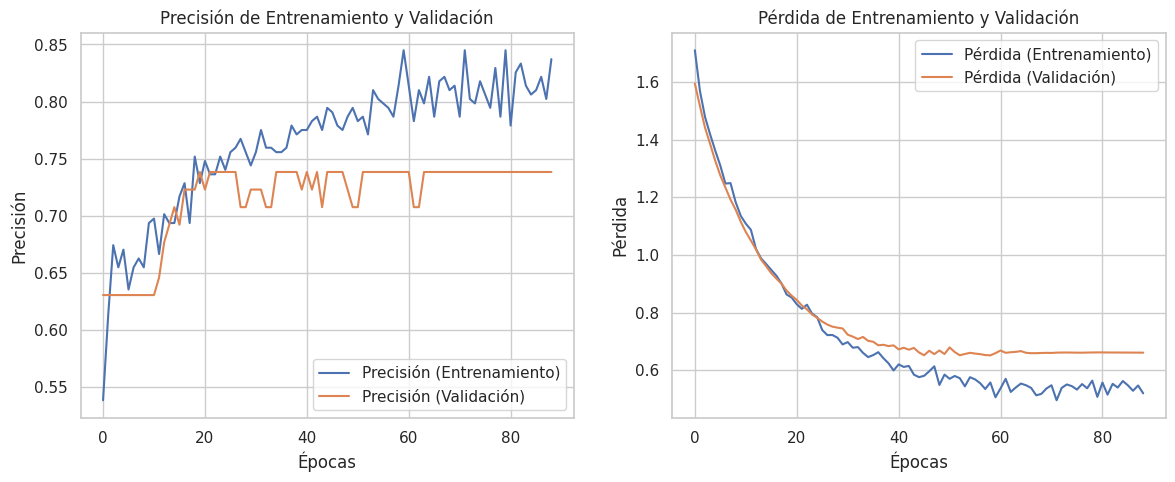


Evaluando el modelo en el conjunto de prueba...
Pérdida en el conjunto de prueba: 0.6535
Precisión en el conjunto de prueba: 0.7410
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        91
           1       0.62      0.65      0.63        48

    accuracy                           0.74       139
   macro avg       0.71      0.72      0.72       139
weighted avg       0.74      0.74      0.74       139



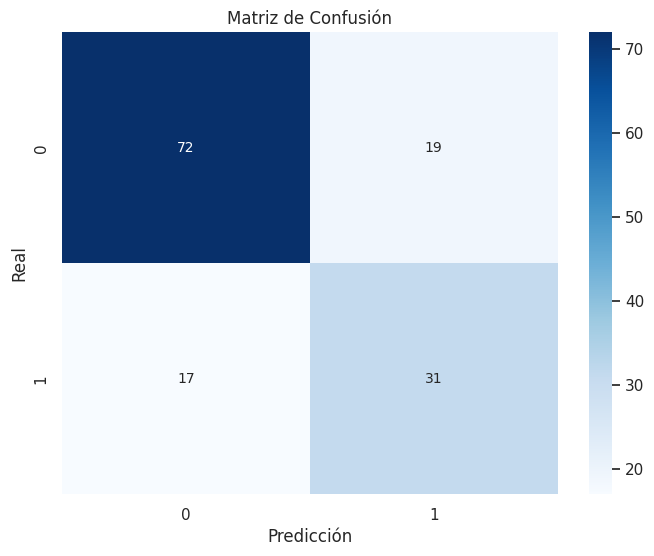

In [17]:
if history2:
    graficar_historial_entrenamiento(history2)

if modelo2:
    evaluar_y_visualizar_clasificacion(modelo2, X_test, y_test)

## 4. Conclusiones del Ejercicio (Clasificación Enfermedad coronaria)

El accuracy del modelo llegó hasta un valor de 0.73, no es suficientemente alto, por lo que aún tendrá varios falsos positivos y varios falsos negativos, sin embargo, al compararse con otros modelos de Marchine Learning como RandomForest, el primero demostró mejores resultados.